In [370]:
import casadi as ca
from scipy.special import binom
import numpy as np
import matplotlib.pyplot as plt

In [379]:
class Bezier:

    def __init__(self, P: ca.SX, T: float):
        self.P = P
        self.m = P.shape[0]
        self.n = P.shape[1]-1
        self.T = T
    
    def bernstein(self, i, t):
        return binom(self.n, i)*t**i*(1 - t)**(self.n-i)
        
    def eval(self, t):
        beta = t/self.T
        s = ca.SX.zeros(self.m, 1)
        for i in range(self.n+1):
            s += self.bernstein(i, beta)*self.P[:, i]
        return s
    
    def deriv(self, m=1):
        D = ca.SX(self.P)
        for j in range(0, m):
            D = (self.n - j)*ca.horzcat(*[ D[:, i+1] - D[:, i] for i in range(self.n - j) ])
        return Bezier(D/self.T**m, self.T)

T = ca.SX.sym('T')
m = 1
n = 6
t = ca.SX.sym('t')
P = ca.SX.sym('P', m, n)
B = Bezier(P, T)
B_dot = B.deriv()
B_ddot = B.deriv().deriv()

p0 = ca.SX.sym('p0', 2, 1)
p1 = ca.SX.sym('p1', 2, 1)

constraints = []
constraints += [(B.eval(0), p0[0])]
constraints += [(B_dot.eval(0), p0[1])]
constraints += [(B_ddot.eval(0), 0)]
constraints += [(B.eval(T), p1[0])]
constraints += [(B_dot.eval(T), p1[1])]
constraints += [(B_ddot.eval(T), 0)]

Y = ca.vertcat(*[c[0] for c in constraints])
b = ca.vertcat(*[c[1] for c in constraints])
A = ca.jacobian(Y, P)
A_inv = ca.inv(A)
P_sol = (A_inv@b).T

f_traj_6_bezier = ca.Function('f', [p0, p1, T], [P_sol], ['p0', 'p1', 'T'], ['P'])

bx = ca.SX.sym('bx', 2, 2)
by = ca.SX.sym('by', 2, 2)


X0 = f_traj_6_bezier(bx[:, 0], bx[:, 1], T)
BX = Bezier(X0, T)
BX_dot = BX.deriv()
BX_ddot = BX_dot.deriv()
x = BX.eval(t)
vx = BX_dot.eval(t)
ax = BX_ddot.eval(t)


Y0 = f_traj_6_bezier(by[0, :], by[1, :], T)
BY = Bezier(X0, T)
BY_dot = BY.deriv()
BY_ddot = BY_dot.deriv()
y = BY.eval(t)
vy = BY_dot.eval(t)
ay = BY_ddot.eval(t)

psi = ca.arctan2(vy, vx)
V = ca.sqrt(vx**2 + vy**2)
omega = (vx*ay - vy*ax)/V

In [380]:
omega

SX(@1=1, @2=(t/T), @3=5, @4=(@3/T), @5=-5, @6=((@5/T)/@4), @7=((bx_1/@4)-(@6*bx_0)), @8=((@3*(@7-bx_0))/T), @9=4, @10=(@1-@2), @11=((@9*((@5/T)-(@3/T)))/T), @12=((@9*(@3/T))/T), @13=((((((@9*(@5/T))/T)+(@11*@6))/@12)*bx_0)-(((@11/@4)/@12)*bx_1)), @14=((@3*(@13-@7))/T), @15=6, @16=((@9*((@5/T)-(@3/T)))/T), @17=(@5/T), @18=((@9*(@5/T))/T), @19=((@3/T)/@17), @20=((((@16/@17)/@18)*bx_3)-((((@16*@19)-((@9*(@3/T))/T))/@18)*bx_2)), @21=((@3*(@20-@13))/T), @22=((bx_3/@17)-(@19*bx_2)), @23=((@3*(@22-@20))/T), @24=((@3*(bx_2-@22))/T), @25=(((((sq(sq((@1-@2)))*@8)+(((@9*@2)*(@10*sq(@10)))*@14))+(((@15*sq(@2))*sq((@1-@2)))*@21))+(((@9*(@2*sq(@2)))*(@1-@2))*@23))+(sq(sq(@2))*@24)), @26=(t/T), @27=(@1-@26), @28=((@3*(@13-@7))/T), @29=((@3*(@7-bx_0))/T), @30=3, @31=((@3*(@20-@13))/T), @32=((@3*(@22-@20))/T), @33=((@3*(bx_2-@22))/T), @34=(t/T), @35=(@1-@34), @36=(((((sq(sq((@1-@34)))*@29)+(((@9*@34)*(@35*sq(@35)))*@28))+(((@15*sq(@34))*sq((@1-@34)))*@31))+(((@9*(@34*sq(@34)))*(@1-@34))*@32))+(sq(sq(@3

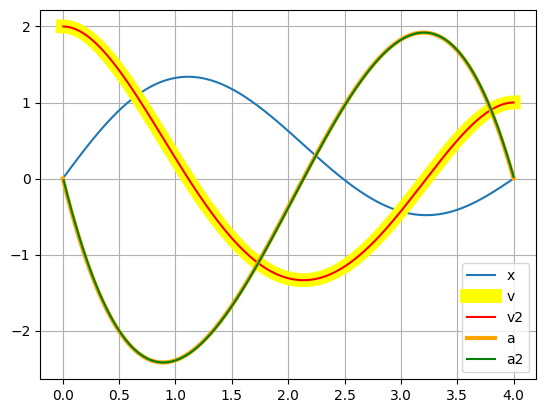

In [375]:
# check bezier with numerical derivatives
def check_bezier():
    T0 = 4
    P0 = f_traj_6_bezier([0, 2], [0, 1], T0)
    B0 = Bezier(P0, T0)
    t = np.linspace(0, T0, 1000)
    x = np.array(ca.DM(B0.eval(t))).reshape(-1)
    v = ca.DM(B0.deriv(1).eval(t))
    a = ca.DM(B0.deriv(2).eval(t))
    v2 = np.diff(x.reshape(-1), axis=0)/np.diff(t, axis=0)
    a2 = np.diff(v2.reshape(-1), axis=0)/np.diff(t[1:], axis=0)

    plt.plot(t, x, label='x')
    plt.plot(t, v, label='v', linewidth=10, color='yellow')
    plt.plot(t[1:], v2, label='v2', color='red')
    plt.plot(t, a, label='a', color='orange', linewidth=3)
    plt.plot(t[2:], a2, label='a2', color='green')
    plt.legend()
    plt.grid()

check_bezier()

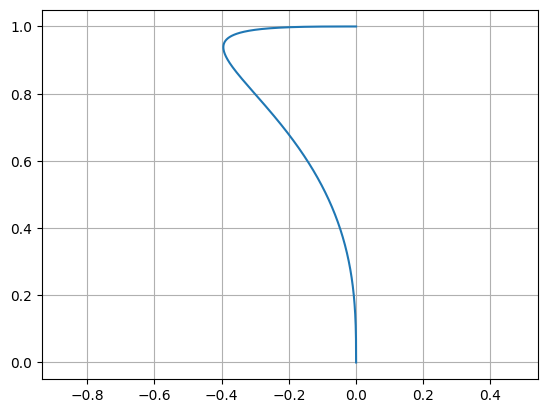

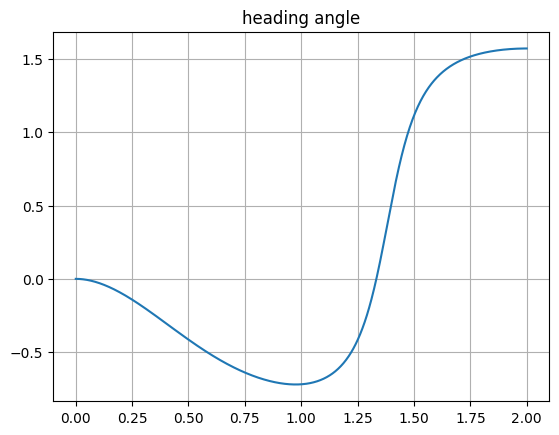

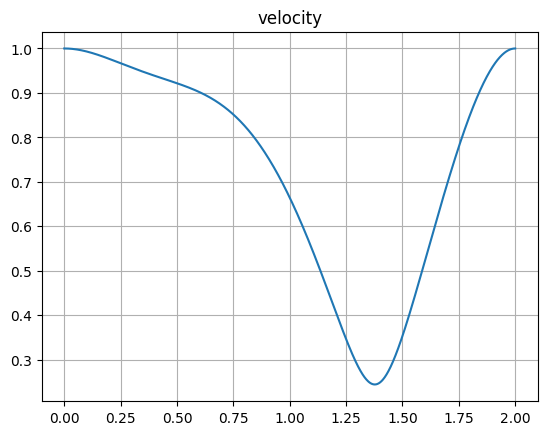

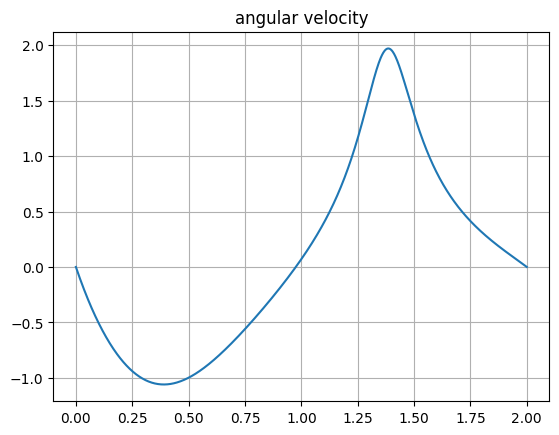

In [369]:
T0 = 2
bc = np.array([
    [ # position
        [0, 0],  # wp0, x, y
        [1, 0]   # wp1, x, y
    ],
    [ # velocity
        [1, 0],
        [0, 1]
    ]
])


t = np.linspace(0, T0, 1000)
X0 = f_traj_6_bezier(bc[:, 0, 0], bc[:, 1, 0], T0)
BX = Bezier(X0, T0)
x = np.array(ca.DM(BX.eval(t))).reshape(-1)
vx = np.array(ca.DM(BX.deriv().eval(t))).reshape(-1)
ax = np.array(ca.DM(BX.deriv(2).eval(t))).reshape(-1)


Y0 = f_traj_6_bezier(bc[0, :, 1], bc[1, :, 1], T0)
BY = Bezier(Y0, T0)
y = np.array(ca.DM(BY.eval(t))).reshape(-1)
vy = np.array(ca.DM(BY.deriv().eval(t))).reshape(-1)
ay = np.array(ca.DM(BY.deriv(2).eval(t))).reshape(-1)

psi = ca.arctan2(vy, vx)
V = ca.sqrt(vx**2 + vy**2)
omega = (vx*ay - vy*ax)/V


plt.plot(y, x)
plt.axis('equal');
plt.grid()

plt.figure()
plt.title('heading angle')
plt.plot(t, psi)
plt.grid()

plt.figure()
plt.title('velocity')
plt.plot(t, V)
plt.grid()

plt.figure()
plt.title('angular velocity')
plt.plot(t, omega)
plt.grid()

In [368]:
bc = ca.SX.sym('bc', 2, 2, 2)
bc

[SX(
 [[bc0_0, bc0_2], 
  [bc0_1, bc0_3]]),
 SX(
 [[bc1_0, bc1_2], 
  [bc1_1, bc1_3]])]